In [439]:
!pip install openpyxl
!pip install pandas-gbq -U
!pip install tableone


In [440]:
import pandas as pd
import sklearn as sk
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
import shap
from tableone import tableone
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

In [441]:
credentials = pydata_google_auth.get_user_credentials(['https://www.googleapis.com/auth/cloud-platform'],)
project = 'capacheiv'
pandas_gbq.context.credentials = credentials

In [443]:
query = ""
for fn in ['icustays', 'demographics', 'labs', 'cancer_diagnosis', 'pastcancer', 'apache_pr','apache_v', 'apache_data',
            'vital', 'admissionlabs', 'patient', 'hospital']:
    with open('sql/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from hospital"
project = 'capacheiv'

gbq_data = pd.read_gbq(query, dialect='standard', project_id=project)

In [467]:
df = gbq_data

In [468]:
df['set'] = df['year_group'].apply(
        lambda x: 'train' if x in ["2010-2014"] else(
            'val_pre_covid' if x == "2015-2019"
           else np.nan
    )
)


df['los_7d'] = df['actualiculos'].apply(lambda x: 1 if x>=7 else 0)
df = df.rename(columns={'mortality': 'in_hospital_mortality',})

df = df.rename(columns={'ethnicity':'Race',
                        'has_sepsis':'Sepsis',
                        'has_cancer':'Cancer'})

In [469]:
df = df.drop(columns=[
 'patienthealthsystemstayid',
 'gender',
 'age',
 'hospitalid',
 'wardid',
 'apacheadmissiondx',
 'admissionheight',
 'hospitaladmittime24',
 'hospitaladmitoffset',
 'hospitaladmitsource',
 'hospitaldischargeyear',
 'hospitaldischargetime24',
 'hospitaldischargeoffset',
 'hospitaldischargelocation',
 'hospitaldischargestatus',
 'unittype',
 'unitadmittime24',
 'unitadmitsource',
 'unitvisitnumber',
 'unitstaytype',
 'admissionweight',
 'dischargeweight',
 'unitdischargetime24',
 'unitdischargeoffset',
 'unitdischargelocation',
 'unitdischargestatus',
 'uniquepid',
 'HOSP_NUM',
 'acutePhysiologyScore',
 'apacheScore',
 'predictedicumortality',
 'predictedhospitalmortality',
 'apacheScore',
 'predictedhospitalmortality',
 'admission_diagnosis',
 'has_icd_code',
 'cancer_diagnosis',
 'past_cancer',
 'teachingstatus',
 'numbedscategory',
 'actualicumortality', 
 'actualiculos',
 'apachescore_int',
 'asactualhospitallos',
 'asacutephysiologyscore',
 'max_hid', 
 'year_group'
])

In [470]:
df.columns.to_list()

['patientunitstayid',
 'Race',
 'age_num',
 'male',
 'female',
 'metastaticcancer',
 'cancer_hemato',
 'cancer_non_hemato',
 'Cancer',
 'Sepsis',
 'in_hospital_mortality',
 'metastasis',
 'gram_positive',
 'gram_negative',
 'yeast',
 'vasopressor',
 'surgical',
 'intubated',
 'vent',
 'dialysis',
 'eyes',
 'motor',
 'verbal',
 'meds',
 'wbc',
 'temperature',
 'respiratoryrate',
 'sodium',
 'meanbp',
 'ph',
 'hematocrit',
 'creatinine',
 'albumin',
 'pao2',
 'pco2',
 'glucose',
 'bilirubin',
 'vent_upon_admission',
 'vent_during_hosp',
 'min_heartrate',
 'max_heartrate',
 'min_respiratoryrate',
 'max_respiratoryrate',
 'min_temperature',
 'max_temperature',
 'min_spo2',
 'max_spo2',
 'min_albumin',
 'max_albumin',
 'mean_albumin',
 'min_bilirubin',
 'max_bilirubin',
 'mean_bilirubin',
 'min_BUN',
 'max_BUN',
 'mean_BUN',
 'min_calcium',
 'max_calcium',
 'mean_calcium',
 'min_creatinine',
 'max_creatinine',
 'mean_creatinine',
 'min_glucose',
 'max_glucose',
 'mean_glucose',
 'min_bicarb

In [471]:
list = ['patientunitstayid', 'male', 'female', 'age_num', 'metastaticcancer', 'cancer_hemato', 'cancer_non_hemato', 'Sepsis',  
        'Cancer', 'metastasis', 'gram_positive', 'gram_negative', 'yeast', 'vasopressor', 'surgical', 'intubated', 'vent',
        'dialysis', 'eyes', 'motor', 'verbal', 'meds', 'vent_upon_admission', 'vent_during_hosp', 
        'Caucasian', 'African_American', 'Hispanic', 'Asian', 'Native_American', 'Other_Unknown_Missing']
for x in list:
    df[x] = df[x].astype(float)

In [472]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,patientunitstayid,Race,age_num,male,female,metastaticcancer,cancer_hemato,cancer_non_hemato,Cancer,Sepsis,in_hospital_mortality,metastasis,gram_positive,gram_negative,yeast,vasopressor,surgical,intubated,vent,dialysis,eyes,motor,verbal,meds,wbc,temperature,respiratoryrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,glucose,bilirubin,vent_upon_admission,vent_during_hosp,min_heartrate,max_heartrate,min_respiratoryrate,max_respiratoryrate,min_temperature,max_temperature,min_spo2,max_spo2,min_albumin,max_albumin,mean_albumin,min_bilirubin,max_bilirubin,mean_bilirubin,min_BUN,max_BUN,mean_BUN,min_calcium,max_calcium,mean_calcium,min_creatinine,max_creatinine,mean_creatinine,min_glucose,max_glucose,mean_glucose,min_bicarbonate,max_bicarbonate,mean_bicarbonate,min_TotalCO2,max_TotalCO2,mean_TotalCO2,min_hematocrit,max_hematocrit,mean_hematocrit,min_hemoglobin,max_hemoglobin,mean_hemoglobin,min_INR,max_INR,mean_INR,min_lactate,max_lactate,mean_lactate,min_platelets,max_platelets,mean_platelets,min_potassium,max_potassium,mean_potassium,min_ptt,max_ptt,mean_ptt,min_sodium,max_sodium,mean_sodium,min_wbc,max_wbc,mean_wbc,min_bands,max_bands,mean_bands,min_alt,max_alt,mean_alt,min_ast,max_ast,mean_ast,min_alp,max_alp,mean_alp,Caucasian,African_American,Hispanic,Asian,Native_American,Other_Unknown_Missing,set,los_7d
0,456195.0,Hispanic,85.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,6.0,5.0,0.0,18.49,35.6,42.0,136.0,41.0,7.315,38.4,3.81,3.6,50.6,37.1,180.0,1.7,0.0,0.0,67.0,139.0,0.0,42.0,35.6,37.3,0.0,97.0,3.6,3.6,3.60,1.7,1.7,1.70,25.0,25.0,25.000000,9.0,9.0,9.00,2.71,2.71,2.710000,138.0,175.0,151.333333,17.0,17.0,17.000000,NaN,NaN,NaN,41.8,41.8,41.800000,14.5,14.5,14.500000,1.2,1.2,1.200000,NaN,NaN,NaN,209.0,209.0,209.000000,3.8,3.8,3.800000,22.5,22.5,22.50,140.0,140.0,140.000000,18.49,18.49,18.490000,NaN,NaN,NaN,23.0,23.0,23.0,71.0,71.0,71.0,112.0,112.0,112.0,0.0,0.0,1.0,0.0,0.0,0.0,train,0
1,480057.0,Hispanic,76.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,1.10,37.7,31.0,147.0,53.0,7.342,37.4,1.91,2.4,119.6,25.0,246.0,2.6,1.0,0.0,114.0,152.0,16.0,30.0,35.8,38.2,71.0,99.0,2.4,3.1,2.75,0.5,2.6,1.55,12.0,17.0,14.500000,8.7,8.7,8.70,0.74,1.37,1.055000,142.0,212.0,192.250000,20.0,25.0,22.500000,NaN,NaN,NaN,27.1,37.4,31.200000,9.3,13.3,10.833333,1.3,1.5,1.433333,1.2,1.2,1.20,47.0,84.0,70.333333,3.0,3.6,3.300000,32.7,35.7,34.20,140.0,147.0,143.500000,0.90,1.10,1.000000,NaN,NaN,NaN,105.0,128.0,116.5,35.0,190.0,112.5,61.0,92.0,76.5,0.0,0.0,1.0,0.0,0.0,0.0,train,0
2,471616.0,Other/Unknown,82.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,5.0,0.0,3.72,40.1,31.0,138.0,156.0,-1.000,27.1,0.68,-1.0,-1.0,-1.0,54.0,-1.0,0.0,0.0,67.0,110.0,15.0,23.0,36.0,40.1,94.0,100.0,2.2,2.2,2.20,7.5,7.5,7.50,18.0,19.0,18.500000,8.2,8.8,8.50,0.71,0.96,0.835000,54.0,116.0,84.800000,18.0,24.0,21.000000,NaN,NaN,NaN,27.1,29.9,28.500000,8.9,10.0,9.450000,1.3,1.3,1.300000,1.6,2.9,2.25,108.0,128.0,118.000000,3.9,4.4,4.150000,36.6,36.6,36.60,133.0,138.0,135.500000,3.72,11.40,7.560000,23.0,23.0,23.0,172.0,172.0,172.0,231.0,231.0,231.0,949.0,949.0,949.0,0.0,0.0,0.0,0.0,0.0,1.0,train,0
3,482408.0,Hispanic,35.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,5.0,0.0,10.70,37.1,26.0,137.0,69.0,-1.000,41.6,0.65,-1.0,-1.0,-1.0,224.0,-1.0,0.0,0.0,84.0,118.0,17.0,26.0,36.3,37.2,93.0,99.0,2.9,3.7,3.26,1.5,3.0,2.22,8.0,13.0,10.000000,8.5,9.5,8.94,0.33,0.65,0.473333,96.0,286.0,173.566667,21.0,25.0,22.833333,NaN,NaN,NaN,40.9,47.7,44.018182,14.2,17.0,15.581818,1.4,1.5,1.466667,NaN,NaN,NaN,23.0,75.0,50.000000,3.5,4.0,3.766667,33.6,36.1,34.85,135.0,140.0,137.666667,5.90,10.70,7.918182,4.0,4.0,4.0,40.0,59.0,48.2,51.0,58.0,53.6,160.0,184.0,169.0,0.0,0.0,1.0,0.0,0.0,0.0,train,0
4,527739.0,Other/Unknown,81.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,5.0,0.0,5.00,36.6,12.0,138.0,43.0,-1.000,27.2,0.38,-1.0,-1.0,-1.0,86.0,-1.0,0.0

In [473]:
def compute_metrics_long_format(y_true,
                                y_pred_proba,
                                seed,
                                target,
                                val_set,
                                sens_attributes,
                                c_test_sens
                               ):
    results = []
    
    for sens_attribute in sens_attributes:
        c_test = c_test_sens[sens_attribute]
    
        unique_classes = c_test.unique()
    
        metrics_list = [
            'AUROC',
            # 'AUPRC',
            'Accuracy',
            'Recall',
            # 'Precision',
            'F1-score',
            # 'Balanced Accuracy'
        ]
        
        functions_list = [
            roc_auc_score,
            # average_precision_score,
            accuracy_score,
            recall_score,
            # precision_score,
            f1_score,
            # balanced_accuracy_score
        ]
    
        for cls in unique_classes:
            idx = c_test == cls
            for metric, func in zip(metrics_list, functions_list):
                try:
                    value = func(y_true[idx], (y_pred_proba[idx] > 0.5).astype(int)) \
                                               if metric not in ['AUROC','AUPRC'] else func(y_true[idx], y_pred_proba[idx])
                except:
                    value = np.nan
                
                results.append({
                    'Task': target,
                    'Validation Set': val_set,
                    'Seed': seed,
                    'Attribute': sens_attribute,
                    'Class': cls,
                    'Metric': metric,
                    'Value': value
                })
    
        # Compute metrics for all classes combined    
        overall_metrics = {}
        for metric, func in zip(metrics_list, functions_list):
            overall_metrics[metric] = func(y_true, (y_pred_proba > 0.5).astype(float))\
                                           if metric not in ['AUROC','AUPRC'] else func(y_true, y_pred_proba)
    
        for metric, value in overall_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': '',
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })
    
        # compute fairness metrics as well
        fairness_metrics = {}
        
        fairness_metrics_list = [
            'Demographic Parity Ratio',
            'Equalized Odds Ratio'
        ]
        
        fairness_functions_list = [
            demographic_parity_ratio,
            equalized_odds_ratio
        ]
    
        for metric, func in zip(fairness_metrics_list, fairness_functions_list):
            fairness_metrics[metric] = func(y_true=y_true,
                                            y_pred=(y_pred_proba > 0.5).astype(int),
                                            sensitive_features=c_test)
    
        for metric, value in fairness_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': sens_attribute,
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })

    return pd.DataFrame(results)

In [474]:
def get_sample_weights(y_train):
    
    classes_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    
    sample_weights = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        sample_weights[i] = classes_weights[int(val)]

    return sample_weights


In [475]:
def train_model(df,
                features,
                target='in_hospital_mortality',
                model=XGBClassifier(),
               ):
    
    X_train = df.loc[df['set'] == 'train', features]
    y_train = df.loc[df['set'] == 'train', target]

    # Train, test, eval model with sample weights
    model.fit(X_train, y_train, sample_weight=get_sample_weights(y_train))
    
    return model


In [476]:
def test_model(df,
               features,
               metrics_all,
               model,
               target='in_hospital_mortality',
               val_set='val_pre_covid',
               sens_attributes=['race', 'Sepsis'],
               seed=42,
              ):


    X_test = df.loc[df['set'] == val_set, features]
    y_test = df.loc[df['set'] == val_set, target]
    
    np.random.seed(s)
    resample = np.random.randint(0, len(X_test), size=int(.8*len(X_test)))

    X_test = X_test.iloc[resample]
    y_test = y_test.iloc[resample]

    # classes of sensitive attributes in the test set
    c_test_sens = df.loc[df['set'] == val_set, sens_attributes].iloc[resample]

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics_fold = compute_metrics_long_format(y_test, y_pred_proba, seed,
                                               target, val_set, sens_attributes, 
                                               c_test_sens)

    metrics_all = pd.concat([metrics_all, metrics_fold], axis=0)

    return metrics_all.drop_duplicates()

In [477]:
def mean_ci_agg(df):
    mean = np.mean(df)
    se = np.std(df) / np.sqrt(len(df))
    ci_width = 1.96 * se
    lower_ci = mean - ci_width
    upper_ci = mean + ci_width
    return f"{mean:.3f} ({lower_ci:.3f} - {upper_ci:.3f})"

In [478]:
def compute_p_value(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]
    
    _, p_value = ttest_ind(*group_values)  

    if p_value < .001:
        return '<.001'
    elif p_value < .01:
        return '<.01'
    else:
        return np.round(p_value, 3)

In [479]:
def calculate_md(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]

    mean_diff = np.mean(group_values[1]) - np.mean(group_values[0])

    return mean_diff

In [480]:
def process_metrics(metrics_all):
    
    pivoted_metrics = metrics_all.pivot(
        index=['Seed', 'Metric', 'Attribute','Class'],
        columns=['Task','Validation Set'],
        values=['Value']
    ).groupby(['Metric', 'Attribute','Class',]) \
     .agg(mean_ci_agg) \
     .droplevel(0,axis=1)

    return pivoted_metrics
    
#     p_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
#                           .apply(compute_p_value) \
#                           .reset_index(name='p_value') \
#                           .pivot(
#                               columns='Task',
#                               index=['Metric', 'Attribute', 'Class'],
#                               values='p_value') \
#                           .round(3)
    
#     p_values.columns = pd.MultiIndex.from_product([p_values.columns, ['p_value']])
#     p_values.columns.name = ('Task', 'Validation Set')
    
#     pivoted_metrics_p = pd.concat([pivoted_metrics, p_values], axis=1)
#     pivoted_metrics_p.columns.name = ('Task', 'Validation Set')

    md_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
        .apply(calculate_md) \
        .reset_index(name='mean_diff') \
        .pivot(
            columns='Task',
            index=['Metric', 'Attribute', 'Class'],
            values='mean_diff') \
        .round(3)

    md_values.columns = pd.MultiIndex.from_product([md_values.columns, ['mean_diff']])
    md_values.columns.name = ('Task', 'Validation Set')

    pivoted_metrics_p = pd.concat([pivoted_metrics, p_values, md_values], axis=1)
    pivoted_metrics_p.columns.name = ('Task', 'Validation Set')
   
    pivoted_metrics_p = pivoted_metrics_p.sort_index(level=[0,1], axis=1, ascending=False)
    
    return pivoted_metrics_p

In [481]:
def get_explain_plot(fit_model, X): 
    explainer = shap.Explainer(fit_model)
    shap_values = explainer.shap_values(X)  
    shap.summary_plot(shap_values, X, plot_size=(8,6)) 

In [482]:
first_units = df.columns[
        df.columns.str.contains('first_careunit')
].tolist()

tableone(df,
         groupby='set',
         columns=['in_hospital_mortality','los_7d','Race', 'Sepsis'],
         order={'in_hospital_mortality':[1,0],'los_7d':[1,0]},
         limit={'in_hospital_mortality': 1,'los_7d': 1},
        )


Grouped by set                                           
                                                     Missing        Overall         train val_pre_covid
n                                                                    136002         64792         71192
in_hospital_mortality, n (%) 1                            18  128375 (94.4)  61221 (94.5)  67154 (94.3)
los_7d, n (%)                1                             0    11254 (8.3)    5363 (8.3)    5891 (8.3)
Race, n (%)                                               18     1607 (1.2)     719 (1.1)     888 (1.2)
                             African American                  15536 (11.4)   7229 (11.2)   8307 (11.7)
                             Asian                               1927 (1.4)    1020 (1.6)     907 (1.3)
                             Caucasian                        104621 (76.9)  49596 (76.5)  55025 (77.3)
                             Hispanic                            5287 (3.9)    2818 (4.3)    2469 (3.5)
                             Native American                      944 (0.7)     465 (0.7)     479 (0.7)
                             Other/Unknown                       6062 (4.5)    2945 (4.5)    3117 (4.4)
Sepsis, n (%)                0.0                          18  112212 (82.5)  53604 (82.7)  58608 (82.3)
                             1.0                               23772 (17.5)  11188 (17.3)  12584 (17.7)

In [483]:
seeds = np.arange(0, 10, 1)
val_sets = ['val_pre_covid']
targets = [
    'in_hospital_mortality',
    'los_7d',
]
sens_attributes = [
    'Race',
    'Sepsis',
]

models = [
    LGBMClassifier(verbosity=-1),
    XGBClassifier(),
]
models_names = ['LGBM', 'XGB']



for model, model_name in zip(models, models_names):
    print(model_name)

    metrics_all = pd.DataFrame()
    
    for t in targets:
        print(t)
        features = df.columns.drop(['in_hospital_mortality','los_7d','set'] + sens_attributes)
        fit_model = train_model(
            df,
            features,
            t,
            model,  
        )
        for vs in val_sets:
                for s in tqdm(seeds):
                    
                    metrics_all = test_model(
                        df,
                        features,
                        metrics_all=metrics_all,
                        model=fit_model,
                        target=t,
                        val_set=vs,
                        sens_attributes=sens_attributes,
                        seed=s,
                    )
        pivoted_metrics = process_metrics(metrics_all)

LGBM
in_hospital_mortality


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


los_7d


100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.43s/it]


XGB
in_hospital_mortality


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


los_7d


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/it]


In [484]:
pivoted_metrics.iloc[(pivoted_metrics.index.get_level_values('Class') == 'Overall')]

Task                                        in_hospital_mortality  \
Validation Set                                      val_pre_covid   
Metric                   Attribute Class                            
AUROC                              Overall  0.892 (0.890 - 0.894)   
Accuracy                           Overall  0.920 (0.919 - 0.921)   
Demographic Parity Ratio Race      Overall  0.958 (0.952 - 0.964)   
                         Sepsis    Overall  0.865 (0.863 - 0.867)   
Equalized Odds Ratio     Race      Overall  0.480 (0.365 - 0.595)   
                         Sepsis    Overall  0.890 (0.875 - 0.906)   
F1-score                           Overall  0.957 (0.956 - 0.957)   
Recall                             Overall  0.941 (0.940 - 0.941)   

Task                                                       los_7d  
Validation Set                                      val_pre_covid  
Metric                   Attribute Class                           
AUROC                              Overall  0.775 (0.773 - 0.777)  
Accuracy                           Overall  0.838 (0.837 - 0.838)  
Demographic Parity Ratio Race      Overall  0.696 (0.663 - 0.730)  
                         Sepsis    Overall  0.488 (0.482 - 0.494)  
Equalized Odds Ratio     Race      Overall  0.652 (0.617 - 0.688)  
                         Sepsis    Overall  0.494 (0.488 - 0.500)  
F1-score                           Overall  0.332 (0.329 - 0.335)  
Recall                             Overall  0.489 (0.485 - 0.493)

In [485]:
pivoted_metrics.iloc[(pivoted_metrics.index.get_level_values('Class') == 'Overall')]

Task                                        in_hospital_mortality  \
Validation Set                                      val_pre_covid   
Metric                   Attribute Class                            
AUROC                              Overall  0.892 (0.890 - 0.894)   
Accuracy                           Overall  0.920 (0.919 - 0.921)   
Demographic Parity Ratio Race      Overall  0.958 (0.952 - 0.964)   
                         Sepsis    Overall  0.865 (0.863 - 0.867)   
Equalized Odds Ratio     Race      Overall  0.480 (0.365 - 0.595)   
                         Sepsis    Overall  0.890 (0.875 - 0.906)   
F1-score                           Overall  0.957 (0.956 - 0.957)   
Recall                             Overall  0.941 (0.940 - 0.941)   

Task                                                       los_7d  
Validation Set                                      val_pre_covid  
Metric                   Attribute Class                           
AUROC                              Overall  0.775 (0.773 - 0.777)  
Accuracy                           Overall  0.838 (0.837 - 0.838)  
Demographic Parity Ratio Race      Overall  0.696 (0.663 - 0.730)  
                         Sepsis    Overall  0.488 (0.482 - 0.494)  
Equalized Odds Ratio     Race      Overall  0.652 (0.617 - 0.688)  
                         Sepsis    Overall  0.494 (0.488 - 0.500)  
F1-score                           Overall  0.332 (0.329 - 0.335)  
Recall                             Overall  0.489 (0.485 - 0.493)

In [486]:
pivoted_metrics

Task                                                 in_hospital_mortality  \
Validation Set                                               val_pre_covid   
Metric                   Attribute Class                                     
AUROC                              Overall           0.892 (0.890 - 0.894)   
                         Race                        0.893 (0.887 - 0.900)   
                                   African American  0.886 (0.877 - 0.894)   
                                   Asian             0.913 (0.905 - 0.921)   
                                   Caucasian         0.890 (0.888 - 0.892)   
                                   Hispanic          0.928 (0.925 - 0.931)   
                                   Native American   0.915 (0.886 - 0.944)   
                                   Other/Unknown     0.903 (0.893 - 0.914)   
                         Sepsis    0.0               0.902 (0.899 - 0.905)   
                                   1.0               0.822 (0.819 - 0.826)   
Accuracy                           Overall           0.920 (0.919 - 0.921)   
                         Race                        0.929 (0.924 - 0.933)   
                                   African American  0.923 (0.922 - 0.925)   
                                   Asian             0.920 (0.913 - 0.926)   
                                   Caucasian         0.917 (0.916 - 0.918)   
                                   Hispanic          0.939 (0.936 - 0.941)   
                                   Native American   0.924 (0.914 - 0.934)   
                                   Other/Unknown     0.931 (0.928 - 0.934)   
                         Sepsis    0.0               0.939 (0.938 - 0.939)   
                                   1.0               0.832 (0.829 - 0.834)   
Demographic Parity Ratio Race      Overall           0.958 (0.952 - 0.964)   
                         Sepsis    Overall           0.865 (0.863 - 0.867)   
Equalized Odds Ratio     Race      Overall           0.480 (0.365 - 0.595)   
                         Sepsis    Overall           0.890 (0.875 - 0.906)   
F1-score                           Overall           0.957 (0.956 - 0.957)   
                         Race                        0.962 (0.959 - 0.964)   
                                   African American  0.959 (0.958 - 0.960)   
                                   Asian             0.957 (0.953 - 0.960)   
                                   Caucasian         0.955 (0.955 - 0.956)   
                                   Hispanic          0.967 (0.966 - 0.969)   
                                   Native American   0.959 (0.953 - 0.964)   
                                   Other/Unknown     0.963 (0.961 - 0.965)   
                         Sepsis    0.0               0.968 (0.967 - 0.968)   
                                   1.0               0.900 (0.899 - 0.901)   
Recall                             Overall           0.941 (0.940 - 0.941)   
                         Race                        0.958 (0.953 - 0.963)   
                                   African American  0.943 (0.941 - 0.945)   
                                   Asian             0.937 (0.931 - 0.942)   
                                   Caucasian         0.939 (0.938 - 0.939)   
                                   Hispanic          0.957 (0.955 - 0.959)   
                                   Native American   0.941 (0.936 - 0.946)   
                                   Other/Unknown     0.951 (0.948 - 0.954)   
                         Sepsis    0.0               0.956 (0.955 - 0.956)   
                                   1.0               0.865 (0.862 - 0.867)   

Task                                                                los_7d  
Validation Set                                               val_pre_covid  
Metric                   Attribute Class                                    
AUROC                              Overall           0.775 (0.773 - 0.777)  
                         

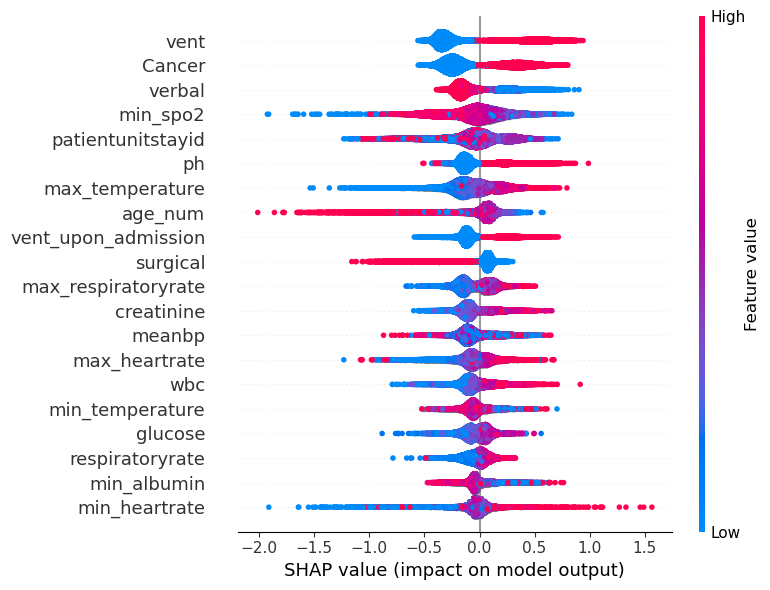

In [487]:
get_explain_plot(fit_model, df.loc[df['set'] == 'train', features])

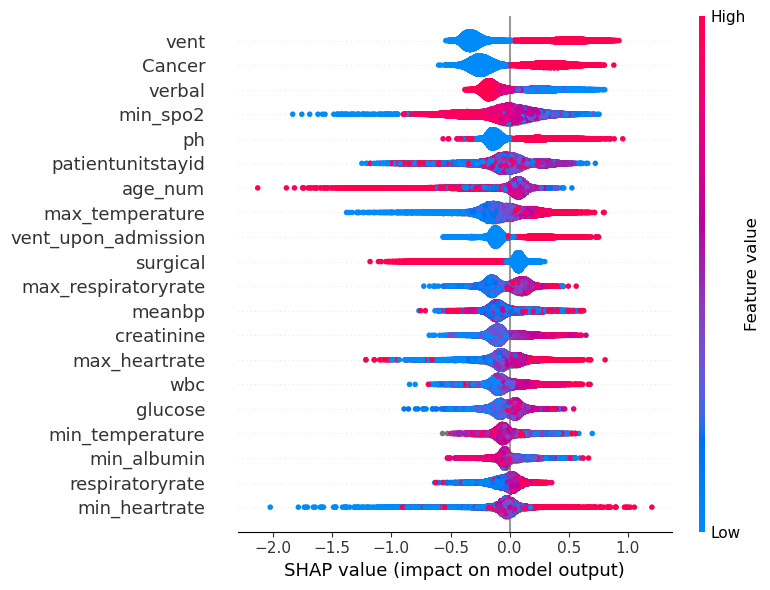

In [488]:
get_explain_plot(fit_model, df.loc[df['set'] == 'val_pre_covid', features])